In [2]:
import numpy as np
import flopy
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import os
import csv
import time
import seaborn as sns
sns.set_style("white")

from scipy.interpolate import interp2d
from scipy.interpolate import griddata
import matplotlib.cm as cm

from flopy.utils.sfroutputfile import SfrFile

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Classifier
from sklearn.tree import ExtraTreeRegressor
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV

from treeFuncs import trainAndEvaluateModel 
from treeFuncs import metrics
from treeFuncs import plotImportance

from spotpy.objectivefunctions import correlationcoefficient as r
from scipy import stats

modws ="C:/Users/davem/Documents/Thesis/modflow/mfoutput"
modws= "D:/mfoutput"

C:\Users\davem\anaconda3\lib\site-packages\spotpy\algorithms\padds.py:5: DeprecationWarning: Please use `ConvexHull` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import ConvexHull, QhullError
C:\Users\davem\anaconda3\lib\site-packages\spotpy\algorithms\padds.py:5: DeprecationWarning: Please use `QhullError` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import ConvexHull, QhullError


In [162]:
col_names = ['K', 'Low_K_ratio', 'Sy', 'Rech', 'ET_valley', 'ET_rip_ratio', 'Stream_K_ratio','Pumping Rate','Qout']
col_dict = {'K':'Base K', 'Low_K_ratio': 'Confining Layer K (as a ratio to Base K)', 'Sy':'Specific Yield', 'Rech':'Recharge', 'ET_valley':'Valley ET', 'ET_rip_ratio':'Riparian ET (as a ratio of Valley ET)', 'Stream_K_ratio':'Streambed K', 'Pumping Rate':'Pumping Well Discharge Factor'}
#col_names = col_dict.keys
# load dataset
#data_old = np.loadtxt("outputs/ModflowSfrWellOutput750Test3.txt")
#data = np.loadtxt("mf_notebooks/ModflowSfrWellOutput750Test5.txt")

#test 7 is the original 8 varying pars - test 11 is with constant K and Recharge
data = np.loadtxt("mf_notebooks/ModflowSfrWellOutput1000Test9.txt")

#data = np.loadtxt("ModflowSfrOutput2500New.txt")
error_list = np.loadtxt("mf_notebooks/ErrorSS_SfrWell1000Test9.txt")
eidx = np.array(error_list)[:,0].astype(int)
# #print(eidx)
temprange = np.arange(1000)

error_free = np.delete(temprange, eidx, axis=0)

df = pd.DataFrame(data, index=error_free, columns = col_names)

print(df.index.shape) #how big is it 

#Set inputs and targets

X = df[col_names[:-1]] 
Y = df[col_names[-1]] #the last column in the saved csv is the flow at reach 49 - this is for ease of testing - other reaches are brought in later 

   

(959,)


C:\Users\davem\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1036: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = self.plt.cm.get_cmap(cmap)
C:\Users\davem\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\davem\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1036: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = self.plt.cm.get_cmap(cmap)


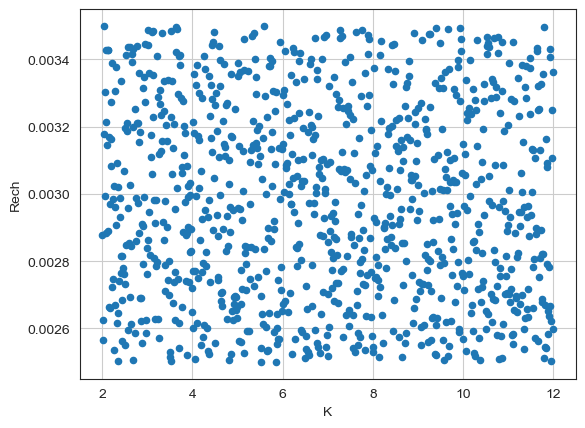

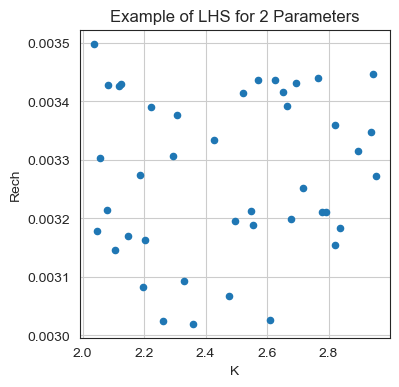

In [90]:
df.plot(kind='scatter',x ='K',y='Rech',grid = True)
sampledf = df[(df['K'] < 3) & (df['K'] > 1) & (df['Rech'] < .004) & (df['Rech'] > .003)]

sampledf.plot(kind='scatter',x ='K',y='Rech',grid = True, figsize=(4,4))
plt.title('Example of LHS for 2 Parameters')
plt.show()

In [183]:
#Save reach flow output as pkl
#ReachQdf.to_pickle('outputs/SS_reachQ.pkl')

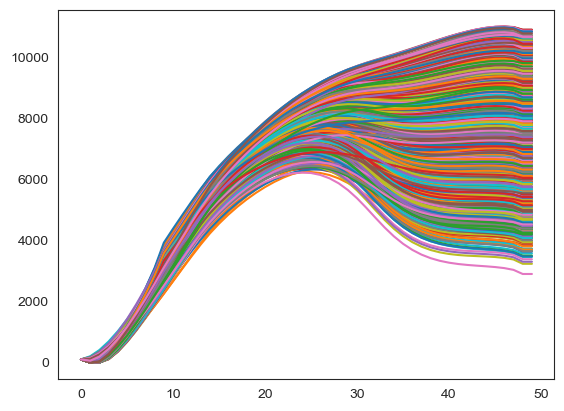

In [92]:
error_list = np.loadtxt("mf_notebooks/ErrorSS_SfrWell1000Test9.txt")
eidx = np.array(error_list)[:,0].astype(int)
# #print(eidx)
temprange = np.arange(1000)
error_free = np.delete(temprange, eidx, axis=0)

# error_list2 = np.loadtxt("outputs/ErrorSS_SfrWell750Test3.txt") #used the error free simulations from test 3 in test 5 so have to bring those in again to remove them to create the error list
# #eidx2 = np.array(error_list2)[:,0].astype(int)
# temprange2 = np.arange(750-len(error_list2))
# #error_free = temprange[eidx]
# error_free = temprange2#np.delete(temprange2, eidx, axis=0)

if eidx.shape[0] == 0:
    error_free = temprange #if no errors

#Sey up arrays to store reach data and budget data
ReachAqf = np.ndarray((len(error_free),50))
#ReachAqf = np.ndarray((100,50)) #for testing CMS
depth = np.ndarray((len(error_free),50))
width = np.ndarray((len(error_free),50))
q = np.ndarray((len(error_free),50))


#Should change this to be multi-level index - one day
for j,i in enumerate(df.index.values):
#for j,i in enumerate(range(100)): #for testing CMS
    modelname = "/ScenarioSfrWell1000Test9_"+str(i) #test 7 has no _ , test 11 does
    sfrout = SfrFile(modws+'\\'+modelname+'.sfr.out')
    Sfrdf = sfrout.get_dataframe() 
   # print(Sfrdf.columns)
    ReachAqf[j] = Sfrdf.Qaquifer
    depth[j] = Sfrdf.depth
    width[j] = Sfrdf.width
    q[j] = Sfrdf.Qout[:]
    plt.plot(Sfrdf.Qout[:])
#plt.yscale('log')    

Text(65.34722222222221, 0.5, 'Discharge (cmd)')

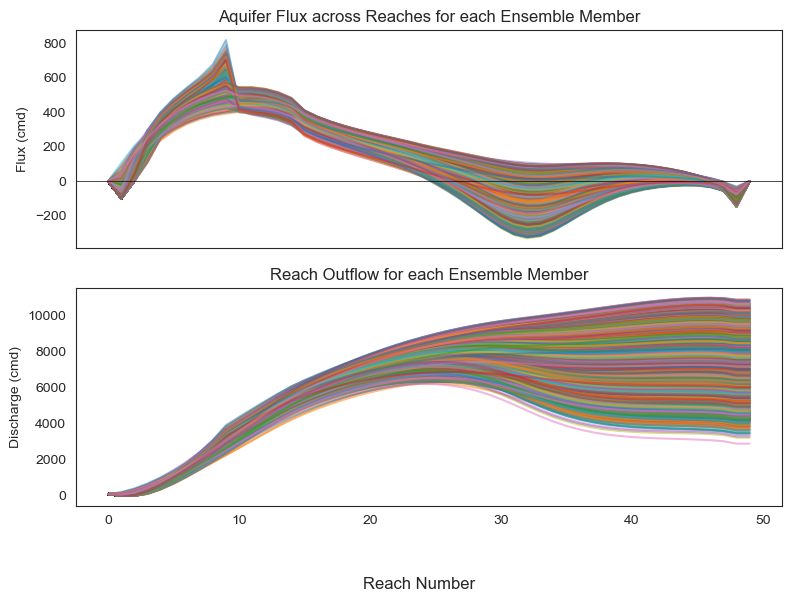

In [93]:
ReachAqfdf = pd.DataFrame(ReachAqf).fillna(0)
depthdf = pd.DataFrame(depth)#.fillna(0)
velocity = np.nan_to_num(q/(depth * width) / 86400) #converting to m/s
vel_df = pd.DataFrame(velocity).fillna(0)
width_df = pd.DataFrame(width).fillna(0)
q_df =pd.DataFrame(q, index = error_free).fillna(0) 
#ReachAqfdf = ReachAqfdf.loc[ReachQdf.index]
#display(ReachAqfdf)

fig, axs = plt.subplots(2, 1, sharex=True, sharey=False,figsize=(8, 6))
#fig.suptitle('Variations in Aquifer Discharge and Stream Reach Outflow across Stream Reaches ')
#fig.supylabel('Discharge (cmd) - Log Scale')
fig.supxlabel('Reach Number')
fig.tight_layout(pad = 2)

for i in ReachAqfdf.index:  
#for i in range(100):
    axs[0].plot(ReachAqfdf.loc[i]*-1, alpha = 0.5) 
    axs[1].plot(q_df.iloc[i], alpha = 0.5)
#     axs[2].plot(vel_df.loc[i], alpha = 0.5)
#     axs[3].plot(depthdf.loc[i], alpha = 0.5)

axs[0].title.set_text('Aquifer Flux across Reaches for each Ensemble Member')
axs[0].set_ylabel('Flux (cmd)')
#axs[2].set_ylim((0,5))
#axs[3].set_ylim((0,20))
axs[0].axhline(0, color='black', linewidth=.5)

axs[1].title.set_text('Reach Outflow for each Ensemble Member')
axs[1].set_ylabel('Discharge (cmd)')
# axs[2].title.set_text('Velocity across All 50 Reaches for All Simulations')
# axs[2].set_ylabel('Velocity (m/s)')
# axs[3].title.set_text('Depth across All 50 Reaches for All Simulations')
# axs[4].set_ylabel('Depth (m)')


In [77]:
#q_df.to_pickle('outputs/SS_reachQ1000_Test9.pkl')

0
Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,  10,
            ...
            990, 991, 992, 993, 994, 995, 996, 997, 998, 999],
           dtype='int64', length=959)
Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,  10,
            ...
            990, 991, 992, 993, 994, 995, 996, 997, 998, 999],
           dtype='int64', length=959)
(959, 50)


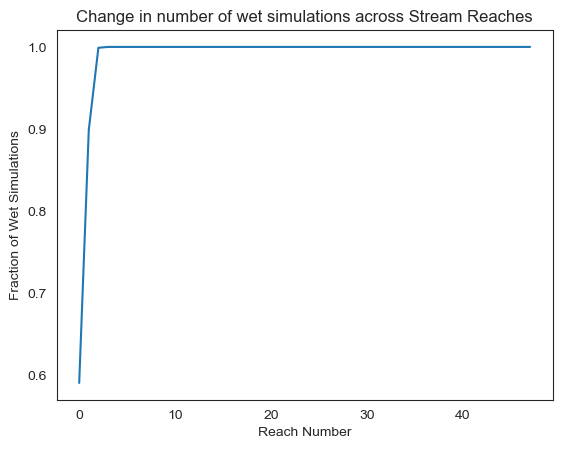

In [163]:
#Getting rid of ensembles with 0 flow
#ReachQdf = pd.read_pickle('outputs/SS_reachQ.pkl')
#ReachQdf = pd.read_pickle('outputs/SS_reachQ_test5.pkl')
ReachQdf = pd.read_pickle('outputs/SS_reachQ1000_Test9.pkl')


#ReachQdf = pd.DataFrame(ReachQ)

numgrz = [len(ReachQdf[i][ReachQdf[i] > 0].index)/len(ReachQdf.index) for i in range(50)] 
print(numgrz.index(max(numgrz[2:])))


#plt.figure(figsize=(11,3))
plt.plot(numgrz[2:])
    
#plt.ylim((0.01,np.max(ReachQdf)+10))
plt.ylabel('Fraction of Wet Simulations')
plt.xlabel('Reach Number')
plt.title('Change in number of wet simulations across Stream Reaches')
plt.margins(0.05)

print(ReachQdf.index)

rn_highest = numgrz.index(max(numgrz[2:])) #find reach with greatest number of wet ensembles 
ReachQdf = ReachQdf[ReachQdf[rn_highest] > 0]
print(ReachQdf.index)
print(ReachQdf.shape)

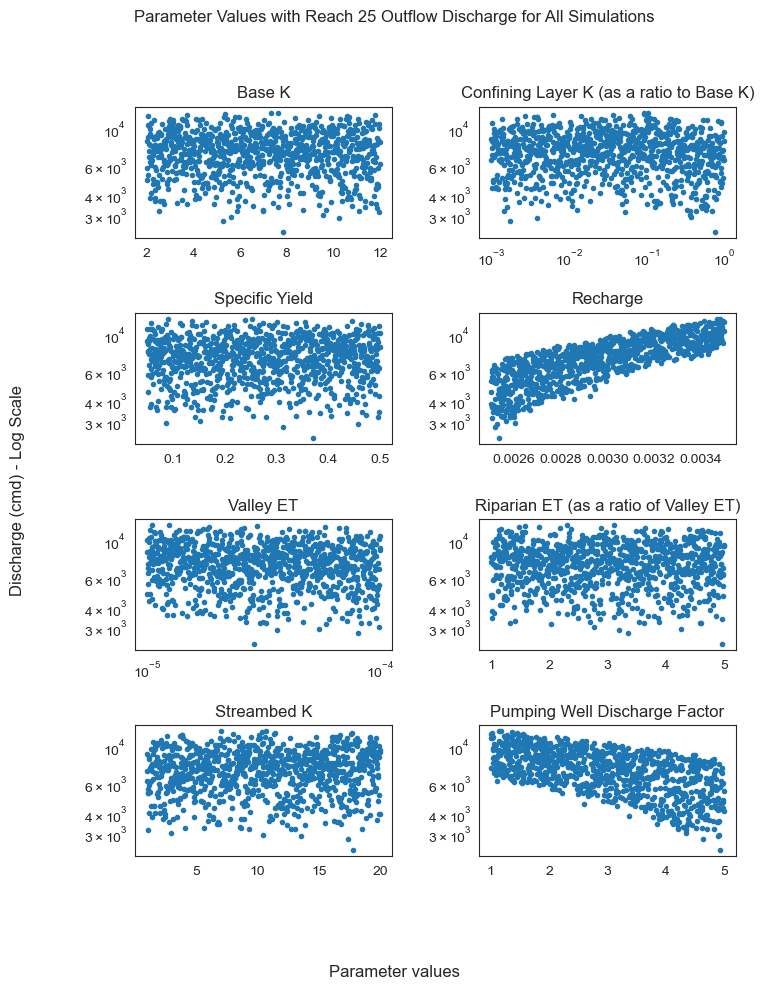

In [164]:
#Plot out the parameters per ensemble discharge at reach 25

#Uncomment line below if pulling from pkl file
#ReachQdf = pd.read_pickle('outputs/SS_reachQ.pkl')

#print(X.index, ReachQdf.index)
params = X.loc[ReachQdf.index]


fig, axs = plt.subplots(4, 2, sharex=False, sharey=False,figsize=(8, 10))
fig.suptitle('Parameter Values with Reach 25 Outflow Discharge for All Simulations')
fig.supylabel('Discharge (cmd) - Log Scale')
fig.supxlabel('Parameter values')
fig.tight_layout(pad = 3.5)
#fig.delaxes(axs[3,1])
# for i in range(len(col_names) - 1):
#     axs.plot(X[col_names[i]],Y,'k.')
i=0
logpars = [1,4]
for row in axs:
    for col in row: 
        col.plot(params[col_names[i]],ReachQdf[32],'.')
        col.title.set_text(col_dict[col_names[i]])
        if i in logpars:
            col.set_xscale('log')
        col.set_yscale('log')
        if i < (len(col_names)-2):
            i+=1
        else:
            break

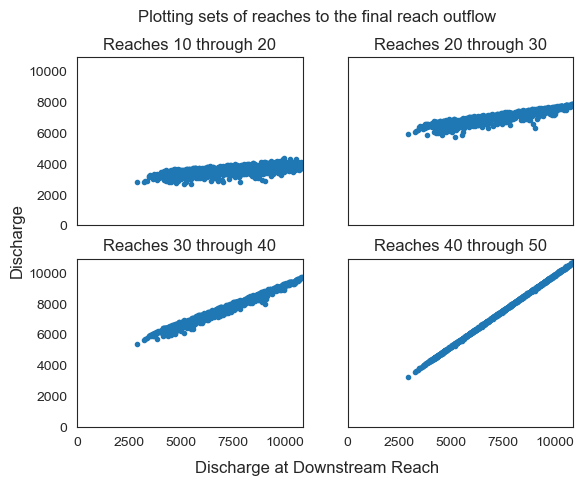

Text(0.5, 0, 'Reach Number')

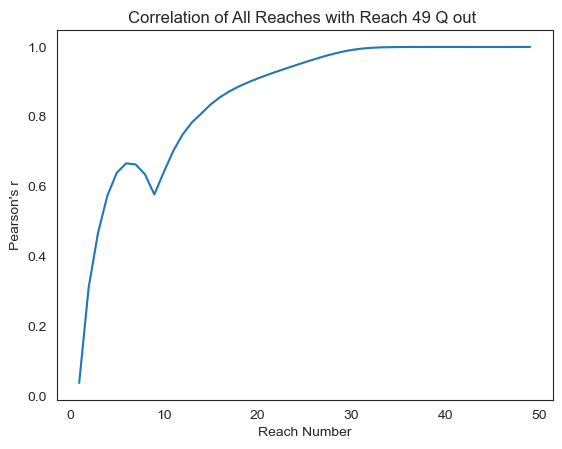

In [96]:
## PLotting out Correlations of reach flows
##examine flows for every reach compared to ds most reach (49)

#print(ReachQdf.head())
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
fig.suptitle('Plotting sets of reaches to the final reach outflow')
fig.supylabel('Discharge')
fig.supxlabel('Discharge at Downstream Reach')

k=10
for row in axs:
    for col in row:        
        for i in range(k,k+10,10):
            col.plot(ReachQdf[49],ReachQdf[i], '.')
            col.title.set_text('Reaches ' +str(k) +' through ' +str(k+10))
        k+=10

plt.xlim(0,int(ReachQdf[49].max()))
plt.ylim(0,int(ReachQdf[49].max()))
plt.show()

    
ReachQdf.corrwith(ReachQdf[49]).plot()
plt.title('Correlation of All Reaches with Reach 49 Q out ')
plt.ylabel('Pearson\'s r')
plt.xlabel('Reach Number')

## Now for the Modflow Cell Heads

The following cells pull the data from the Modflow output files and save as pkls 

In [97]:
#load in Ibound and find active cells in model

ibound = np.loadtxt('base/ibound_lyr1.txt')            
all_well_loc = np.asarray(np.where(ibound == 1)).T
print(all_well_loc) #nrow, ncol

[[ 1  5]
 [ 1  6]
 [ 1  7]
 ...
 [48 16]
 [48 17]
 [48 18]]


In [82]:
#Get Head data for All active wells

error_list = np.loadtxt("mf_notebooks/ErrorSS_SfrWell1000Test9.txt")
eidx = np.array(error_list)[:,0].astype(int)
#print(eidx)
temprange = np.arange(1000)

# error_list2 = np.loadtxt("outputs/ErrorSS_SfrWell750Test3.txt") #used the error free simulations from test 3 in test 5 so have to bring those in again to remove them to create the error list
# #eidx2 = np.array(error_list2)[:,0].astype(int)
# temprange2 = np.arange(750-len(error_list2))
# #error_free = temprange[eidx]

error_free = np.delete(temprange, eidx, axis=0)

error_free = ReachQdf.index.values

well_head = np.empty((len(error_free),all_well_loc.shape[0]))
well_error_sim = []
#well_error_num = []
for j, i in enumerate(error_free):
#for j, i in enumerate(df_flow.index):
    modelname = "ScenarioSfrWell1000Test9_"+str(i)
    headobj = flopy.utils.binaryfile.HeadFile(modws+'/'+modelname+'.hds')
    head = headobj.get_alldata(nodata=0)#-9.9998999e+02)
    
    for k in range(all_well_loc.shape[0]):        
        well_head[j][k] = head[0][0][int(all_well_loc[k][0])][int(all_well_loc[k][1])]        #ntime, nlay, nrow, ncol
        #if (well_head[k][j] < 0) or (well_head[k][j] > 200) or np.isnan(well_head[k][j]):
        if (well_head[j][k] > 120 or np.isnan(well_head[j][k]) or well_head[j][k] < 0):
            well_error_sim.append(i)
            
well_head_df = pd.DataFrame(well_head, index = ReachQdf.index)

new_zone = ReachQdf.loc[~ReachQdf.index.isin(np.unique(well_error_sim))]
well_head_df = well_head_df.loc[new_zone.index]

print(len(well_head_df.index))

well_head_df.to_pickle('outputs/heads/WellHead_SS1000Test9.pkl')


957


In [165]:
#well_head_df.to_pickle('outputs/heads/WellHead_SS_test4.pkl')

#if not pulling new heads
#well_head_df = pd.read_pickle('outputs/heads/WellHead_SS.pkl')
#well_head_df= pd.read_pickle('outputs/heads/WellHead_SStest5.pkl')
well_head_df= pd.read_pickle('outputs/heads/WellHead_SS1000Test9.pkl')

#well_head_df= pd.read_pickle('WellHead_SStest5.pkl')

print(well_head_df.index)
print(ReachQdf.index)


# Since some ensemble members are dropped in the well_head_df
# we change ReachQdf to use the same ensemble members as well_head_df
ReachQdf = ReachQdf.loc[well_head_df.index]


Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,  10,
            ...
            990, 991, 992, 993, 994, 995, 996, 997, 998, 999],
           dtype='int64', length=959)
Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,  10,
            ...
            990, 991, 992, 993, 994, 995, 996, 997, 998, 999],
           dtype='int64', length=959)


### No Pumping Cells

The following 3 cells pull the data from the modflow files and save the no-pumping heads and streamflows as pickles. The last cell also creates the differnce dataframes for both heads and pumping cells.

In [131]:
#Pulling head values for runs without pumping
#using the pumping simulations df index to match 
members = np.loadtxt("mf_notebooks/ModflowSfrWellOutput1000Test9NoPumping.txt")
well_head = np.empty((len(members),all_well_loc.shape[0]))

for j, i in enumerate(members):
#for j, i in enumerate(df_flow.index):
    modelname = "ScenarioSfrWell1000Test9NoPumping_"+str(int(i))
    headobj = flopy.utils.binaryfile.HeadFile(modws+'/'+modelname+'.hds')
    head = headobj.get_alldata(nodata=0)#-9.9998999e+02)
    
    for k in range(all_well_loc.shape[0]):        
        well_head[j][k] = head[0][0][int(all_well_loc[k][0])][int(all_well_loc[k][1])]        #ntime, nlay, nrow, ncol

No_pumping_well_head_df = pd.DataFrame(well_head, index = members)

#save to pickle
No_pumping_well_head_df.to_pickle('outputs/heads/WellHead_SS1000Test9NoPumping.pkl')


In [132]:
#Pulling out the values from the SFR file for the No Pumping runs
NoPumpQ = np.ndarray((len(members),50))
for j,i in enumerate(members):
    modelname = "/ScenarioSfrWell1000Test9NoPumping_"+str(int(i))
    sfrout = SfrFile(modws+'\\'+modelname+'.sfr.out')
    Sfrdf = sfrout.get_dataframe() 
    NoPumpQ[j] = Sfrdf.Qout[:]
    
NoPumpingReachQ = pd.DataFrame(NoPumpQ, index = members)

NoPumpingReachQ.to_pickle('outputs/SS_reachQ1000_Test9NoPumping.pkl')
#plt.yscale('log') 

,0,1,2,3,4,5,6,7,8,9,...,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011
0.0,0.826874,0.838707,0.857697,0.880402,0.907158,0.930458,0.958344,0.990273,1.025696,1.064110,...,0.038887,0.039230,0.039650,0.040138,0.040688,0.041290,0.041931,0.042572,0.043167,0.043610
1.0,1.618698,1.641441,1.677986,1.721741,1.773293,1.817970,1.872536,1.935081,2.004562,2.080223,...,0.234314,0.237991,0.242500,0.247620,0.253242,0.259285,0.265747,0.271965,0.277641,0.281845
2.0,1.184013,1.201401,1.229332,1.262810,1.302269,1.336449,1.377296,1.424126,1.476158,1.532669,...,0.047508,0.048180,0.048973,0.049881,0.050880,0.051964,0.053116,0.054237,0.055275,0.056046
3.0,0.890312,0.902588,0.922295,0.945839,0.973495,0.995369,1.023163,1.055725,1.092400,1.132828,...,0.174904,0.177704,0.181290,0.185471,0.190155,0.195274,0.200783,0.206100,0.210938,0.214500
4.0,0.952927,0.966835,0.989197,1.016045,1.047714,1.075958,1.109634,1.148125,1.190857,1.237259,...,0.053574,0.054466,0.055527,0.056725,0.058044,0.059448,0.060951,0.062408,0.063751,0.064751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995.0,0.421967,0.427963,0.437592,0.449097,0.462654,0.474174,0.487839,0.503510,0.520920,0.539810,...,0.030228,0.030563,0.030952,0.031395,0.031898,0.032433,0.033012,0.033569,0.034088,0.034477
996.0,1.660080,1.682129,1.717453,1.759521,1.808754,1.841537,1.885391,1.938385,1.999451,2.067863,...,0.518570,0.525185,0.534241,0.545242,0.557922,0.572067,0.587532,0.602547,0.616211,0.626259
997.0,1.330513,1.349449,1.379890,1.416397,1.459427,1.497505,1.543358,1.595764,1.653908,1.717094,...,0.149582,0.151962,0.154823,0.158073,0.161621,0.165443,0.169502,0.173439,0.177032,0.179710
998.0,0.310669,0.315178,0.322426,0.331131,0.341393,0.350479,0.361313,0.373703,0.387451,0.402367,...,0.013161,0.013359,0.013596,0.013847,0.014145,0.014450,0.014786,0.015114,0.015411,0.015633


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0.0,0.0,0.0000,0.000,29.404,73.77,107.94,140.06,171.8,204.0,237.1,...,4281.3,4366.6,4437.6,4494.9,4540.6,4575.4,4600.1,4612.9,4609.2,4609.2
1.0,0.0,56.7550,113.290,170.610,229.17,289.30,351.60,416.8,486.1,560.5,...,7308.0,7459.9,7587.7,7693.4,7777.7,7842.4,7888.6,7916.3,7922.9,7922.9
2.0,0.0,0.0000,58.563,102.100,143.58,184.90,226.90,269.9,314.4,360.9,...,6319.9,6446.2,6550.1,6635.2,6703.4,6755.1,6790.2,6809.6,6806.3,6806.3
3.0,0.0,0.0000,29.562,81.300,123.09,163.61,205.10,248.9,297.5,356.5,...,3635.1,3711.0,3774.6,3828.1,3870.9,3903.2,3927.8,3941.8,3945.0,3945.0
4.0,0.0,31.5900,62.910,94.680,127.00,160.10,194.30,229.7,266.8,306.0,...,4959.0,5058.0,5142.0,5209.0,5264.0,5306.0,5335.0,5351.0,5353.0,5353.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995.0,0.0,0.0000,0.000,23.970,41.93,58.38,74.40,90.5,106.9,123.8,...,2169.9,2213.8,2250.4,2279.8,2303.4,2322.3,2334.4,2341.7,2341.7,2341.7
996.0,0.0,0.0000,0.000,139.428,236.56,327.64,419.82,518.0,629.4,770.3,...,5432.9,5545.4,5642.0,5722.7,5789.3,5841.3,5879.5,5902.6,5908.7,5908.7
997.0,0.0,45.6140,91.120,137.180,184.10,232.20,282.10,333.9,388.4,446.4,...,6351.3,6483.7,6594.3,6684.4,6756.9,6813.1,6852.9,6876.0,6882.1,6882.1
998.0,0.0,0.0000,15.670,27.280,38.35,49.40,60.60,72.1,84.1,96.6,...,1637.0,1669.0,1696.0,1719.0,1736.0,1750.0,1759.0,1765.0,1765.0,1765.0


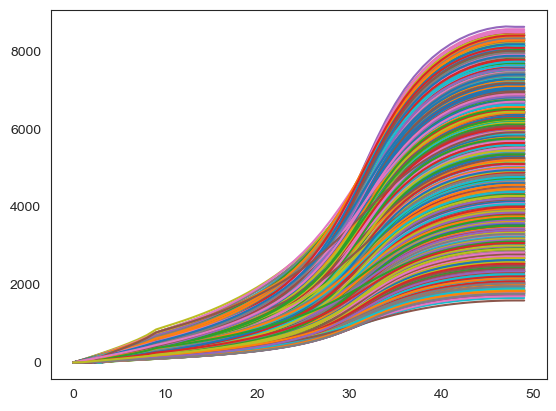

In [166]:
#Calculating the difference in heads from the wells and in the flows from with the well and without
NoPumpingReachQ = pd.read_pickle('outputs/SS_reachQ1000_test9NoPumping.pkl')
No_pumping_well_head_df = pd.read_pickle('outputs/heads/WellHead_SS1000test9NoPumping.pkl')
members = np.loadtxt("mf_notebooks/ModflowSfrWellOutput1000Test9NoPumping.txt")

diff_head_df = No_pumping_well_head_df - well_head_df.loc[members.astype('int')]
diff_reachq_df = NoPumpingReachQ - ReachQdf.loc[members.astype('int')]

#diff_head_df = diff_head_df.round(0)
display(diff_head_df)
display(diff_reachq_df)
for i in members:
    diff_reachq_df.loc[i].plot()

## Using Heads to predict stream Flow

In [167]:
## Setting up the head inputs - dropping out the downstream most CH boundary and the river cells 

river_well_loc = np.where(all_well_loc[:,0] == 25)
#river_well_loc = np.where((all_well_loc[:,0] > 23) & (all_well_loc[:,0] < 27))

CHBound_loc = np.where(all_well_loc[:,1] > 47)
RechBound_loc = np.where(all_well_loc[:,1] < 10) #
upperRows = np.where(all_well_loc[:,0] > 35)
lowerRows = np.where(all_well_loc[:,0] < 15)
drop_locs= np.concatenate((CHBound_loc,upperRows,lowerRows,RechBound_loc), axis = 1)

#drop_locs= np.concatenate((river_well_loc, CHBound_loc,upperRows,lowerRows,RechBound_loc), axis = 1)
drop_locs= np.concatenate((river_well_loc, CHBound_loc), axis = 1)
#drop_locs= np.concatenate((river_well_loc, CHBound_loc, RechBound_loc), axis = 1)


#For testing out all the cells
drop_locs = [[]]

# well_head_noRiv = well_head_df.drop(drop_locs[0], axis = 1)
# new_zone_q = ReachQdf.loc[well_head_noRiv.index]

#Below for diff dfs
well_head_noRiv = diff_head_df.drop(drop_locs[0], axis = 1)
new_zone_q = diff_reachq_df.loc[well_head_noRiv.index]

well_head_noRiv.columns = well_head_noRiv.columns.astype(str)

well_loc_df = pd.DataFrame(all_well_loc).drop(drop_locs[0])
print(well_head_noRiv.shape)


#Normalizing inputs (?) - not currently using 
# norm_well_df = (well_head_noRiv - np.min(well_head_noRiv.min().values))
# norm_well_df = norm_well_df / np.max(well_head_noRiv.max().values)
# norm_well_df.columns = norm_well_df.columns.astype(str)

# norm_q_df = (new_zone_q - np.min(new_zone_q.min().values))
# norm_q_df = norm_q_df/ np.max(new_zone_q.max().values)

# display(well_head_noRiv)
# display(norm_well_df)
# display(norm_q_df)

(939, 2012)


### Plotting out Heads
The next couple of cells calculates the spatial statistics including standard deviation, mean, pearson's correaltion for the hydraulic head values. It also computs spearnmans'rank correlation for the feature-to-target correaltions plot.

In [168]:
from treeFuncs import wellmesh_correlation
dist = 1

# corrmatrix = well_head_df.corr()
# neighbor_corr_avg, neighbor_corr_min = wellmesh_correlation(all_well_loc,well_head_df, dist)

#Below for diff_head_df
neighbor_corr_avg, neighbor_corr_min = wellmesh_correlation(all_well_loc,diff_head_df, dist)
corrmatrix = diff_head_df.corr()

well num, well col, well row 

844 21 31


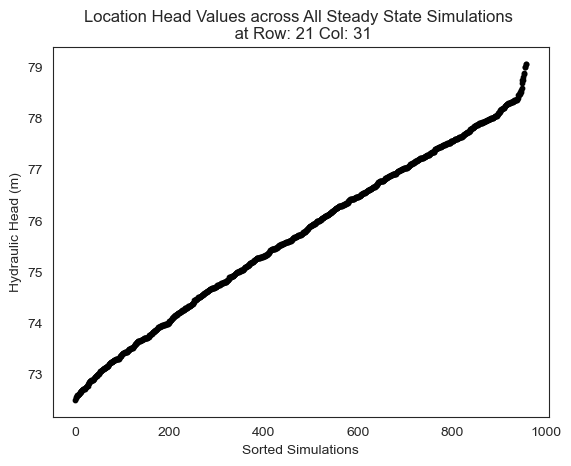

C:\Users\davem\AppData\Local\Temp\ipykernel_13844\1017420977.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r",lut=30)


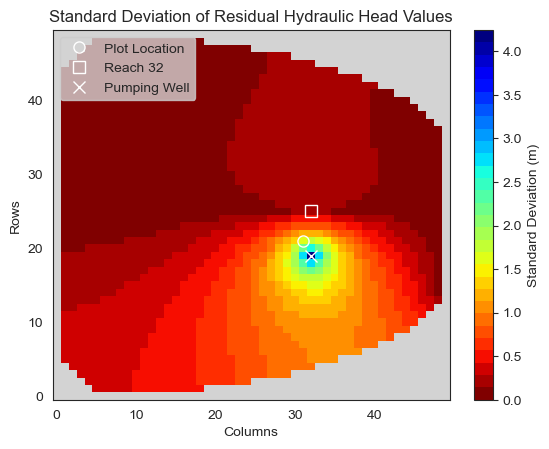

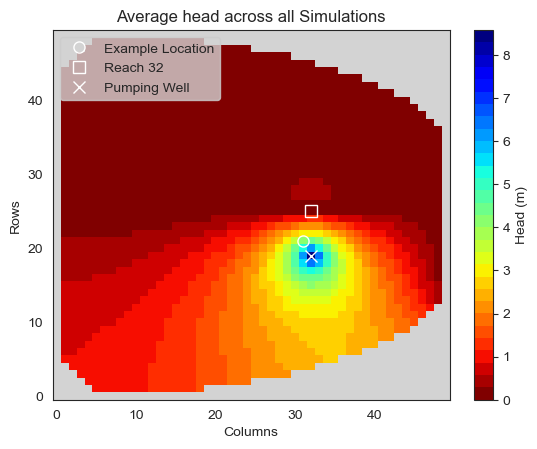

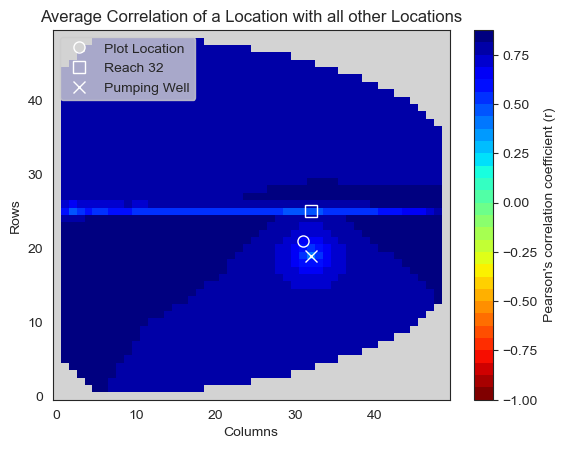

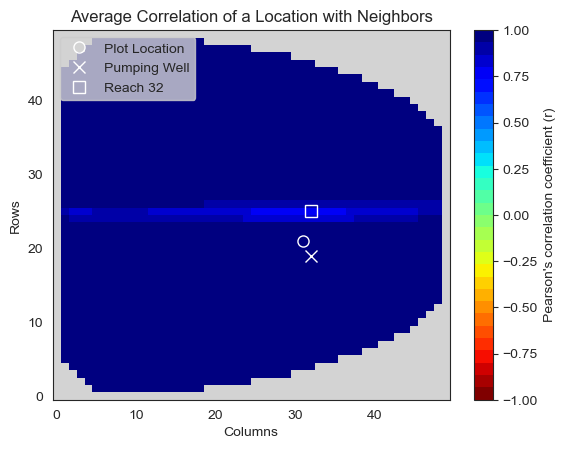

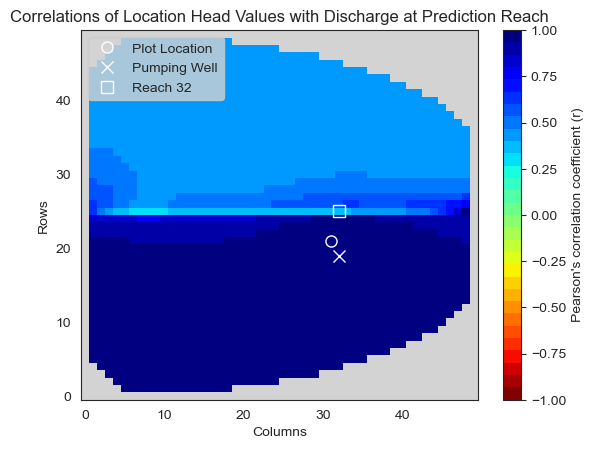

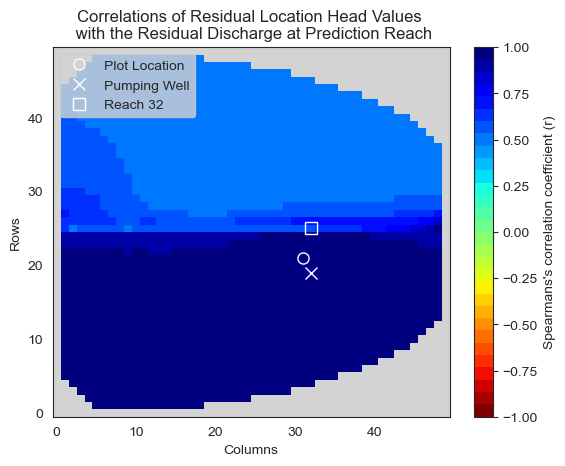

In [169]:
wn = 844
print("well num, well col, well row \n")
print(wn,int(all_well_loc[wn][0]), int(all_well_loc[wn][1]))

plt.scatter(range(len(well_head_df[wn].index)),well_head_df[wn].sort_values(), s = 10, c='k')
plt.xlabel('Sorted Simulations')
plt.ylabel('Hydraulic Head (m)')
plt.title("Location Head Values across All Steady State Simulations \n at Row: " +str(all_well_loc[wn][0])+ " Col: " + str(all_well_loc[wn][1]))
plt.show()

# wn = 1100
# print("well num, well col, well row \n")
# print(wn,int(all_well_loc[wn][0]), int(all_well_loc[wn][1]))

# plt.scatter(range(len(diff_head_df[wn].index)),diff_head_df[wn].sort_values(), s = 10, c='k')
# plt.xlabel('Sorted Simulations')
# plt.ylabel('Hydraulic Head (m)')
# plt.title("Location Head Values across All Steady State Simulations \n at Row: " +str(all_well_loc[wn][0])+ " Col: " + str(all_well_loc[wn][1]))


ztop = np.genfromtxt('base/base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)


kk = np.arange(0,50)
gg = np.arange(0,50)
GG, KK = np.meshgrid(gg,kk)

wellmesh = np.ndarray((50,50))
wellmesh[:][:] = -1e30

wellmesh2 = wellmesh.copy()
mesh_feat_to_target = wellmesh.copy()
spearmans_feat_to_target = wellmesh.copy()
p_value_feat_to_target = wellmesh.copy()
wellmesh_corr = wellmesh.copy()
minmesh = wellmesh.copy()


#Reach number for feature to target correlation
rn = 25

#well_head_df[1060].plot()
#print(int(all_well_loc[wn, 0]),int(all_well_loc[wn, 1]))
for i in range(all_well_loc.shape[0]):
    
#     wellmesh[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = well_head_df[i].std()    
#     rho, p = stats.spearmanr(new_zone_q[rn],well_head_df[i]) 
#     mesh_feat_to_target[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = r(new_zone_q[rn],well_head_df[i])
#     wellmesh2[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = well_head_df[i].mean() #- ztop[int(all_well_loc[i, 0]),int(all_well_loc[i, 1])]
    
   # Diff Heads
    rho, p = stats.spearmanr(new_zone_q[rn],diff_head_df[i])
    wellmesh2[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = diff_head_df[i].mean() 
    wellmesh[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = diff_head_df[i].std()
    mesh_feat_to_target[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = r(new_zone_q[rn],diff_head_df[i])

    wellmesh_corr[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = corrmatrix[i].mean()
    minmesh[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = corrmatrix[i].min()
    spearmans_feat_to_target[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = rho


cmap2 = cm.get_cmap("jet_r",lut=30)
cmap2.set_under("lightgray")
river = np.ndarray((48,))
river[:] = 25

#plt.figure(figsize=(8,6))

reach_label = "Reach " + str(rn)

plt.pcolormesh(KK,GG,wellmesh,cmap = cmap2, vmin = 0,shading='nearest')
plt.colorbar(label = 'Standard Deviation (m)')
plt.plot(int(all_well_loc[wn][1]), int(all_well_loc[wn][0]), marker="o", markersize=8, color="w", mfc='none', linestyle = "None", label="Plot Location")
#plt.plot(range(1,49),river, color="lightblue",label='River')
plt.plot(rn,25, marker="s", markersize=8, color="w", mfc='none', linestyle = "None", label=reach_label)
plt.plot(32,19, marker="x", markersize=8, color="w", mfc='none', linestyle = "None", label="Pumping Well")
plt.legend(facecolor='lightgray', loc='upper left')
plt.xlabel('Columns')
plt.ylabel('Rows')

plt.title('Standard Deviation of Residual Hydraulic Head Values')
#plt.title('Standard Deviation of Hydraulic Head Values')

plt.show()


#plt.figure(figsize=(8,6))

plt.pcolormesh(KK,GG,wellmesh2,cmap = cmap2,vmin=0, shading='nearest')
plt.colorbar(label = 'Head (m)')
plt.plot(int(all_well_loc[wn][1]), int(all_well_loc[wn][0]), marker="o", markersize=8, color="White", mfc='none', linestyle = "None", label="Example Location")
plt.plot(rn,25, marker="s", markersize=8, color="w", mfc='none', linestyle = "None", label=reach_label)
plt.plot(32,19, marker="x", markersize=8, color="w", mfc='none', linestyle = "None", label="Pumping Well")
plt.legend(facecolor='lightgray', loc='upper left')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Average head across all Simulations')
plt.show()

# plt.figure(figsize=(8,6))

plt.pcolormesh(KK,GG,wellmesh_corr,cmap = cmap2, vmin=-1,shading='nearest')
plt.colorbar(label = 'Pearson\'s correlation coefficient (r)')
plt.plot(int(all_well_loc[wn][1]), int(all_well_loc[wn][0]), marker="o", markersize=8, color="White", mfc='none', linestyle = "None", label="Plot Location")
plt.plot(rn,25, marker="s", markersize=8, color="w", mfc='none', linestyle = "None", label=reach_label)
plt.plot(32,19, marker="x", markersize=8, color="w", mfc='none', linestyle = "None", label="Pumping Well")
plt.legend(facecolor='lightgray', loc='upper left')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Average Correlation of a Location with all other Locations')
plt.show()
# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')

#plt.imshow(wellmesh, cmap='RdBu')

plt.pcolormesh(KK,GG,neighbor_corr_avg,cmap = cmap2,vmin=-1, vmax = 1, shading='nearest')
plt.colorbar(label = 'Pearson\'s correlation coefficient (r)')
plt.plot(int(all_well_loc[wn][1]), int(all_well_loc[wn][0]), marker="o", markersize=8, color="White", mfc='none', linestyle = "None", label="Plot Location")
plt.plot(32,19, marker="x", markersize=8, color="w", mfc='none', linestyle = "None", label="Pumping Well")
plt.plot(rn,25, marker="s", markersize=8, color="w", mfc='none', linestyle = "None", label=reach_label)
plt.legend(facecolor='lightgray', loc='upper left')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Average Correlation of a Location with Neighbors')
plt.show()

plt.pcolormesh(KK,GG,mesh_feat_to_target,cmap = cmap2,vmin=-1, vmax=1, shading='nearest')
plt.colorbar(label = 'Pearson\'s correlation coefficient (r)')
plt.plot(int(all_well_loc[wn][1]), int(all_well_loc[wn][0]), marker="o", markersize=8, color="White", mfc='none', linestyle = "None", label="Plot Location")
plt.plot(32,19, marker="x", markersize=8, color="w", mfc='none', linestyle = "None", label="Pumping Well")
plt.plot(rn,25, marker="s", markersize=8, color="w", mfc='none', linestyle = "None", label=reach_label)
plt.legend(facecolor='lightgray', loc='upper left')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Correlations of Location Head Values with Discharge at Prediction Reach')
plt.show()


plt.pcolormesh(KK,GG,spearmans_feat_to_target,cmap = cmap2,vmin=-1, vmax=1, shading='nearest')
plt.colorbar(label = 'Spearmans\'s correlation coefficient (r)')
plt.plot(int(all_well_loc[wn][1]), int(all_well_loc[wn][0]), marker="o", markersize=8, color="White", mfc='none', linestyle = "None", label="Plot Location")
plt.plot(32,19, marker="x", markersize=8, color="w", mfc='none', linestyle = "None", label="Pumping Well")
plt.plot(rn,25, marker="s", markersize=8, color="w", mfc='none', linestyle = "None", label=reach_label)
plt.legend(facecolor='lightgray', loc='upper left')
plt.xlabel('Columns')
plt.ylabel('Rows')

plt.title('Correlations of Residual Location Head Values \n with the Residual Discharge at Prediction Reach')
#plt.title('Correlations of Location Head Values \n with Discharge at Prediction Reach')
plt.show()

# plt.pcolormesh(KK,GG,p_value_feat_to_target,cmap = cmap2, shading='nearest')
# plt.colorbar(label = 'P-value From Spearmans')
# plt.plot(32,19, marker="o", markersize=8, color="k", mfc='none', linestyle = "None", label="Pumping Well")
# plt.plot(rn,25, marker="s", markersize=8, color="k", mfc='none', linestyle = "None", label=reach_label)
# plt.legend(loc='lower right')
# plt.xlabel('Columns')
# plt.ylabel('Rows')
# plt.title('Correlations of Location Head Values with Discharge at Prediction Reach')
# plt.show()

## Tree using Wells to predict Qout

In [177]:
#Best pars from Hyperparmeter Tuning notbook saved here as a dictionary
random_state = 29

#DIFF best pars 
best_pars_dt = {'splitter': 'best','max_features': 1.0,'min_samples_split': 2, 'min_samples_leaf': 2, 'min_impurity_decrease': 5, 'max_leaf_nodes': None, 'max_depth': 4, 'criterion': 'squared_error'}

#best_pars_dt = {'splitter': 'best','max_features': 1.0,'min_samples_split': 15, 'min_samples_leaf': 1, 'min_impurity_decrease': 15, 'max_leaf_nodes': 86, 'max_depth': 5, 'criterion': 'friedman_mse'}


#best_pars_dt = {'min_samples_split': 15, 'min_samples_leaf': 2, 'min_impurity_decrease': 15, 'max_leaf_nodes': 56, 'max_depth': 4, 'criterion': 'friedman_mse'}#best_pars_dt = None
#best_pars_dt = {'splitter': 'best', 'min_samples_split': 15, 'min_samples_leaf': 2, 'min_impurity_decrease': 35, 'max_leaf_nodes': 263, 'max_features': 1.0, 'max_depth': 7, 'criterion': 'squared_error',  'random_state': 1}
#best_pars_dt = {'criterion' : 'absolute_error','min_impurity_decrease': 0.01}

Shape of Input Samples: (939, 2012)
Shape of Output Targets: (939,)
Total time: 1.9588112831115723


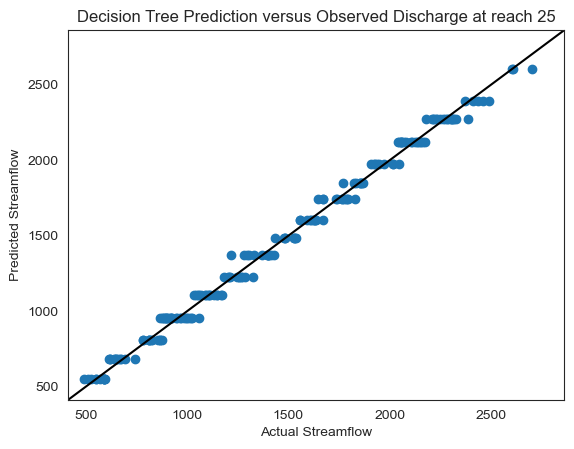

bias       0.111099
rmse      47.669032
r          0.996620
nse        0.993211
lognse     0.991099
kge        0.990144
dtype: float64


In [178]:
# Split dataset into training set and test set, default here is 30% test
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import trainAndEvaluateModel
from treeFuncs import metrics

t0 = time.time()
n = 1


#new_zone_q = np.log(ReachQdf.loc[well_head_noRiv.index]+1)
#new_zone_q = ReachQdf.loc[well_head_noRiv.index]

rn = 25
#imp_df, metrics_df, impurity_list, Tree, y_test, y_pred = trainAndEvaluateModel(DecisionTreeRegressor, norm_well_df, norm_q_df[rn], None, 0.2, n, random_state)  
#imp_df, metrics_df, impurity_list, Tree, y_test, y_pred = trainAndEvaluateModel(DecisionTreeRegressor, well_head_noRiv, new_zone_q[rn], None, 0.2, n, random_state)  

imp_df, metrics_df, impurity_list, Tree, y_test, y_pred = trainAndEvaluateModel(DecisionTreeRegressor, well_head_noRiv, new_zone_q[rn], best_pars_dt, 0.2, n, random_state)  

print('Total time: ' + str(time.time()-t0))

plt.figure()
plt.scatter(y_test, y_pred)

outmax = np.max(y_pred) *1.1
outmin = np.min(y_pred) *0.75

plt.plot([outmin, outmax], [outmin, outmax], color='k', linestyle='-')

lim_tup = (outmin,outmax)
plt.ylim(lim_tup)
plt.xlim(lim_tup)

plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
title = "Decision Tree Prediction versus Observed Discharge at reach " + str(rn)
plt.title(title)
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()

print(metrics_df.mean())

       bias       rmse        r       nse    lognse       kge
0  0.111099  47.669032  0.99662  0.993211  0.991099  0.990144


453    0.739653
475    0.118483
51     0.080140
485    0.013024
293    0.013014
Name: 0, dtype: float64

[0.7396525509939625, 0.11848265339814341, 0.08014037607364646]


Text(0.5, 0, 'Node Number')

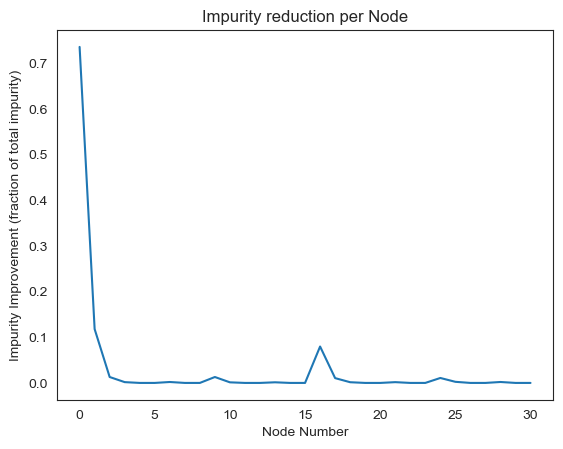

In [179]:
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import evalTree


print(metrics_df)
#tree.plot_tree(Tree)
treeimp = pd.DataFrame(Tree.feature_importances_, index = Tree.feature_names_in_)
#display(treeimp)
display(treeimp[0].nlargest(5))
#display(Tree.feature_names_in_[1017])
#print(Tree.feature_importances_)
#print(Tree.max_features_)
#print(Tree.n_features_in_)
print(sorted(Tree.feature_importances_, reverse=True)[:3])
from treeFuncs import quickEvalTree
imp_improv = quickEvalTree(Tree)
n_nodes = Tree.tree_.node_count
# for i in range(n_nodes):
#     print(str(i) + ': ' +str(Tree.tree_.impurity[i]))
plt.plot(imp_improv)
plt.title('Impurity reduction per Node')
plt.ylabel('Impurity Improvement (fraction of total impurity)')
plt.xlabel('Node Number')
#help(tree._tree.Tree)

In [172]:
#Save the importance DF for later
imp_df.to_pickle('outputs/importance/SSTest9Diff_DT_Impdf.pkl')

Shape of Input Samples: (939, 2012)
Shape of Output Targets: (939,)
Total time: 23.609570503234863
Fraction of wet simulations: 1.0
bias        0.610601
rmse      185.804232
r           0.935439
nse         0.878532
lognse      0.866186
kge         0.913414
dtype: float64


Text(0.5, 1.0, 'Example Random Decision Tree Regression for Q at reach 25')

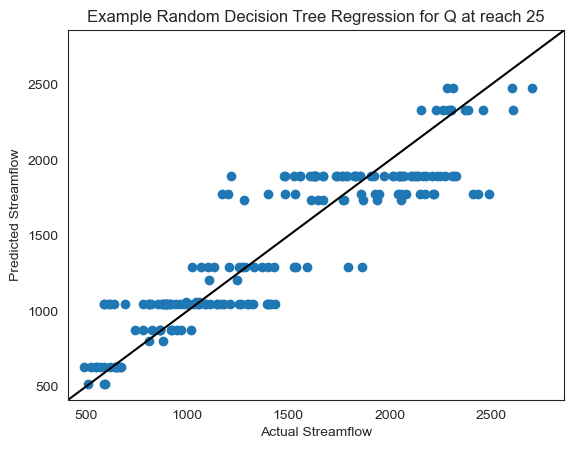

In [180]:
# RANDOM Tree 
# Split dataset into training set and test set, default here is 30% test
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import trainAndEvaluateModel

t0 = time.time()
n = 100

#Splitter is random and max features is set to 1, note that 1.0 is all in the new Sklearn so this is a little confusing
#lastest and greatest - plus splitter setting to best
#Diff best Pars
best_pars_dt_rand = {'splitter': 'best','max_features': 1,'min_samples_split': 2, 'min_samples_leaf': 2, 'min_impurity_decrease': 5, 'max_leaf_nodes': None, 'max_depth': 4, 'criterion': 'squared_error'}

#best_pars_dt_rand = {'splitter': 'best','max_features': 1,'min_samples_split': 15, 'min_samples_leaf': 1, 'min_impurity_decrease': 15, 'max_leaf_nodes': 86, 'max_depth': 5, 'criterion': 'friedman_mse'}


#best_pars_dt_rand = {'max_features': 1, 'max_depth': 7, 'criterion': 'absolute_error', 'min_impurity_decrease': 0.01}
#best_pars_dt_rand = {'splitter': 'best', 'max_features': 1}

#imp_df_rand, metrics_df_rand, rand_impurity_list, randTree, y_test, y_pred = trainAndEvaluateModel(ExtraTreeRegressor, norm_well_df, norm_q_df[rn], best_pars_dt_rand, 0.2, n, random_state)  

imp_df_rand, metrics_df_rand, rand_impurity_list, randTree, y_test, y_pred = trainAndEvaluateModel(ExtraTreeRegressor, well_head_noRiv, new_zone_q[rn], best_pars_dt_rand, 0.2, n, random_state)  

t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[rn]> 0].index) / len(new_zone_q.index)))

#print(metrics_df_rand.mean(),metrics_df_rand.std())
print(metrics_df_rand.mean())
plt.figure()
plt.scatter(y_test, y_pred)

plt.plot([outmin, outmax], [outmin, outmax], color='k', linestyle='-')

lim_tup = (outmin,outmax)
plt.ylim(lim_tup)
plt.xlim(lim_tup)

plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
title = "Example Random Decision Tree Regression for Q at reach " + str(rn)
plt.title(title)

In [174]:
#Save the importance DF for later
imp_df_rand.to_pickle('outputs/importance/SSTest9Diff_RFT_Impdf.pkl')

C:\Users\davem\Documents\Thesis\mf-trees\treeFuncs.py:120: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2.set_under("k")
C:\Users\davem\Documents\Thesis\mf-trees\treeFuncs.py:120: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2.set_under("k")


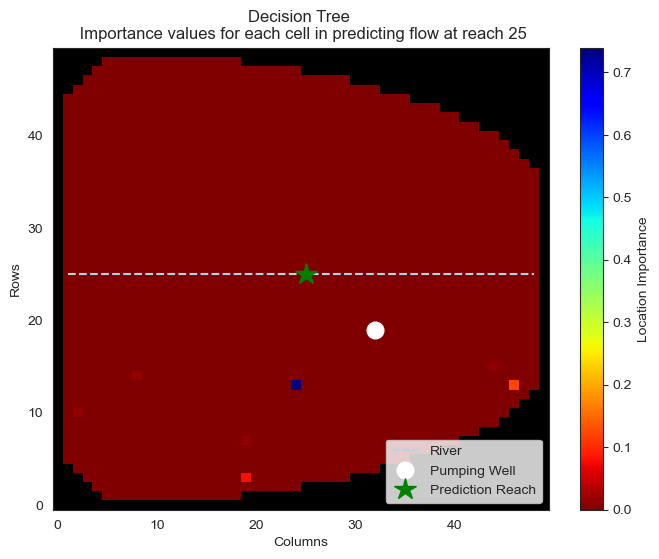

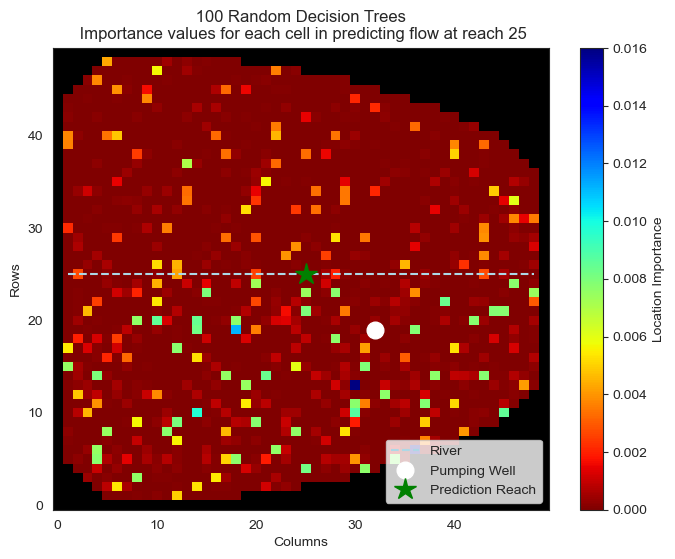

In [181]:
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import plotImportance

numTS = 1
n = 100

title = 'Decision Tree \n Importance values for each cell in predicting flow at reach ' + str(rn)

wellmesh_df = plotImportance(imp_df,well_head_noRiv, well_loc_df,numTS,1,rn,title)

title_rand = ' 100 Random Decision Trees \n Importance values for each cell in predicting flow at reach ' + str(rn)

wellmesh_rand = plotImportance(imp_df_rand,well_head_noRiv, well_loc_df,numTS,n,rn,title_rand)


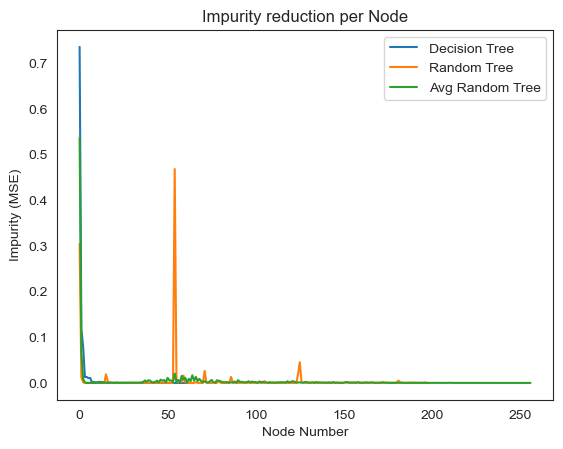

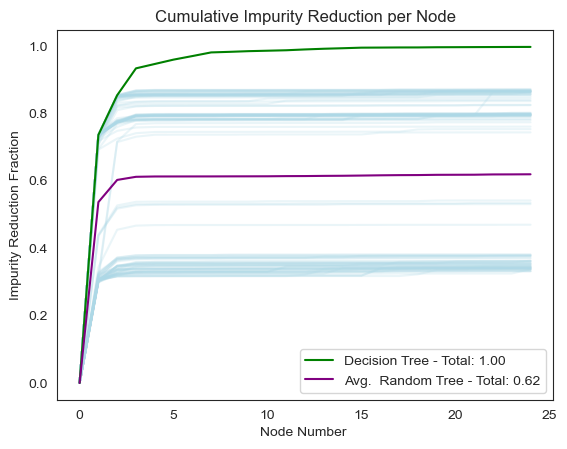

In [176]:
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import evalTree

impurity_df = pd.DataFrame(rand_impurity_list).fillna(0)
avg_rand_impurity = impurity_df.mean(axis = 0)

max_rand_idx = impurity_df.iloc[:,:2].sum(axis=1).idxmax()
#print(max_rand_idx)
#print(impurity_df)
max_rand_impurity = impurity_df.loc[max_rand_idx]

min_rand_idx = impurity_df.sum(axis = 1).idxmin()
min_rand_idx = impurity_df[0].idxmin()

min_rand_impurity = impurity_df.loc[min_rand_idx]
#display(impurity_df)
#print(Tree.max_features_)
#print(Tree.n_features_in_)
#print(sorted(randTree.feature_importances_, reverse=True)[:3])
#from treeFuncs import evalTree
rand_imp_improv = quickEvalTree(randTree)

plt.plot(imp_improv, label = "Decision Tree")
plt.plot(rand_imp_improv, label ="Random Tree")
plt.plot(avg_rand_impurity, label ="Avg Random Tree")
plt.title('Impurity reduction per Node')
plt.ylabel('Impurity (MSE)')
plt.xlabel('Node Number')
plt.legend()
#help(tree._tree.Tree)
plt.show()

#quick cumulative function that inserts 0 at beginning 
def cumImpurity(imp):
    nodes = 25
    return np.cumsum(np.insert(imp,0,0))[:nodes] #inserting 0 at the beginning - essentially to indicate the original impurity reduction (0)

dt_impurity_cumulative = cumImpurity(imp_improv)
#rand_impurity_cumulative = cumImpurity(rand_imp_improv)[:50]
avgrand_impurity_cumulative = cumImpurity(avg_rand_impurity.to_numpy())
maxrand_impurity_cumulative = cumImpurity(max_rand_impurity.to_numpy())
minrand_impurity_cumulative = cumImpurity(min_rand_impurity.to_numpy())
x_nodes = np.arange(len(minrand_impurity_cumulative))
          
for i in range(n):
    single_impurity = cumImpurity(impurity_df.loc[i].to_numpy())
    plt.plot(single_impurity, color='lightblue', alpha = 0.25)
    
plt.plot(dt_impurity_cumulative, markersize = 4, color='g', label = "Decision Tree - Total: {:.2f}".format(np.max(dt_impurity_cumulative)))
#plt.plot(rand_impurity_cumulative, markersize = 4, marker= 'o', label ="Random Tree - Total: {:.2f}".format(np.max(rand_impurity_cumulative)))
plt.plot(avgrand_impurity_cumulative, markersize = 4, color='purple', label ="Avg.  Random Tree - Total: {:.2f}".format(np.max(avgrand_impurity_cumulative)))
#plt.fill_between(x_nodes,maxrand_impurity_cumulative, minrand_impurity_cumulative, alpha = 0.2, label ="Min and Max Random Tree")
#plt.plot(maxrand_impurity_cumulative, markersize = 4,marker='.', label ="Max  Random Tree - Total: {:.2f}".format(np.max(avgrand_impurity_cumulative)))
    
plt.title('Cumulative Impurity Reduction per Node')
plt.ylabel('Impurity Reduction Fraction')
plt.xlabel('Node Number ')
plt.xticks(minor=True)
plt.legend()

## Gradient Boosting

In [182]:
#print(xgr_random.scorer_,xgr_random.best_score_)

#diff best pars
best_pars_gr = {'subsample': 0.7, 'n_estimators': 75, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_impurity_decrease': 5, 'max_leaf_nodes': None, 'max_depth': 5, 'loss': 'squared_error', 'learning_rate': 0.2, 'criterion': 'friedman_mse'}


#best_pars_gr = {'subsample': 0.6, 'n_estimators': 175, 'min_samples_split': 15, 'min_samples_leaf': 1, 'min_impurity_decrease': 25, 'max_leaf_nodes': 86, 'max_depth': 4, 'loss': 'huber', 'learning_rate': 0.1, 'criterion': 'friedman_mse'}
#old pars
#best_pars_gr = {'subsample':1.0, 'n_estimators': 175, 'min_samples_split': 5, 'min_samples_leaf': 4, 'min_impurity_decrease': 45, 'max_leaf_nodes': 52, 'max_features': 1.0, 'max_depth': 3, 'loss': 'squared_error','learning_rate': 0.1, 'criterion': 'friedman_mse', 'random_state':3}

#best_pars_gr = {'subsample': 0.6, 'n_estimators': 175, 'min_samples_split': 5, 'min_samples_leaf': 4, 'min_impurity_decrease': 45, 'max_leaf_nodes': 52, 'max_features': 1.0, 'max_depth': 3, 'loss': 'squared_error', 'criterion': 'friedman_mse'}

Shape of Input Samples: (939, 2012)
Shape of Output Targets: (939,)
Total time: 194.11387395858765


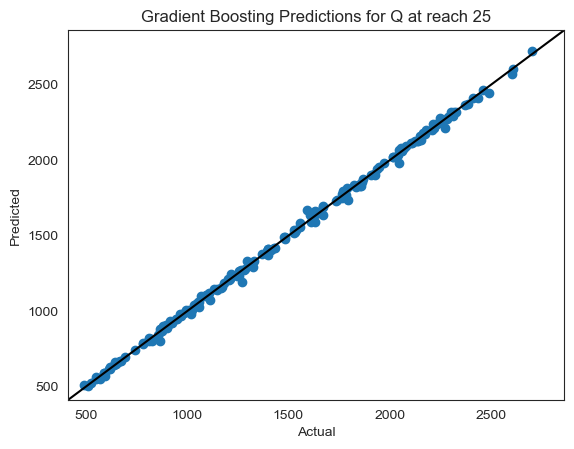

       bias       rmse         r       nse    lognse       kge
0 -0.036073  19.077528  0.999457  0.998913  0.998862  0.999266


In [183]:
# Split dataset into training set and test set, default here is 30% test
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import trainAndEvaluateModel

t0 = time.time()
n = 1

gr_imp_df, metrics_df_gr, impurity_gr, Tree, y_test, y_pred = trainAndEvaluateModel(GradientBoostingRegressor, well_head_noRiv, new_zone_q[rn], best_pars_gr, 0.2, n, random_state)  


t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

plt.figure()
plt.scatter(y_test, y_pred)

plt.plot([outmin, outmax], [outmin, outmax], color='k', linestyle='-')

lim_tup = (outmin,outmax)
plt.ylim(lim_tup)
plt.xlim(lim_tup)


plt.xlabel("Actual")
plt.ylabel("Predicted")
title = "Gradient Boosting Predictions for Q at reach " + str(rn)
plt.title(title)

plt.show()
print(metrics_df_gr)

[381]


,0,1
381,11,45


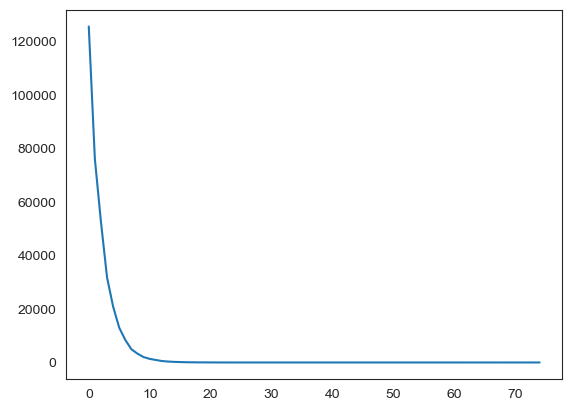

In [184]:
#display(gr_imp_df)
MostImp = []
for i in range(n):
    MostImp.append(int(gr_imp_df[i].idxmax()))

countlist = [MostImp.count(i) for i in MostImp]
print(MostImp)
#print(countlist)
display(well_loc_df.loc[MostImp])

oob_improvement = Tree.oob_improvement_

plt.plot(oob_improvement)

In [185]:
#Save the importance DF for later
gr_imp_df.to_pickle('outputs/importance/SSTest9Diff_GB_Impdf.pkl')

C:\Users\davem\Documents\Thesis\mf-trees\treeFuncs.py:120: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2.set_under("k")


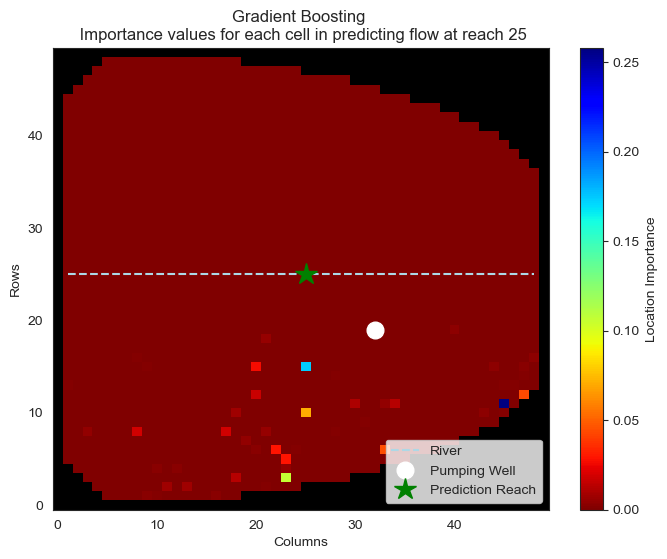

In [186]:
n=1
title_gr = 'Gradient Boosting \n Importance values for each cell in predicting flow at reach ' + str(rn)
wellmesh_gr = plotImportance(gr_imp_df,well_head_noRiv, well_loc_df,1,n,rn,title_gr)

## Random Forest - Steady State

In [187]:
#new best RF
#Best Diff Pars
best_pars_rf = {'n_estimators': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 45, 'max_samples': 0.9, 'max_leaf_nodes': None, 'max_depth': 7, 'criterion': 'friedman_mse'

#best_pars_rf = {'n_estimators': 225, 'min_samples_split': 5, 'min_samples_leaf': 2, 'min_impurity_decrease': 25, 'max_samples': 0.9, 'max_leaf_nodes': None, 'max_depth': 4, 'criterion': 'friedman_mse'} #max_depth was 7

#best_pars_rf = {'n_estimators': 175, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 5, 'max_samples': 0.3, 'max_leaf_nodes': None, 'max_depth': 7, 'criterion': 'friedman_mse'}
#best_pars_rf = {'n_estimators': 125, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 15, 'max_samples': 0.9, 'max_leaf_nodes': 154, 'max_features': 1.0, 'max_depth': 7, 'criterion': 'friedman_mse'}
#best_pars_rf = {'max_depth': 4, 'criterion' : 'absolute_error','min_impurity_decrease': 0.01}


In [ ]:
# Split dataset into training set and test set, default here is 30% test
t0 = time.time()
n = 1
rn = 28
    
rf_imp_df, metrics_df_rf, impurity_list, Tree, y_test, y_pred = trainAndEvaluateModel(RandomForestRegressor, well_head_noRiv, new_zone_q[rn], best_pars_rf, 0.2, n, random_state)  

t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

print(metrics_df_rf)

Shape of Input Samples: (939, 2012)
Shape of Output Targets: (939,)


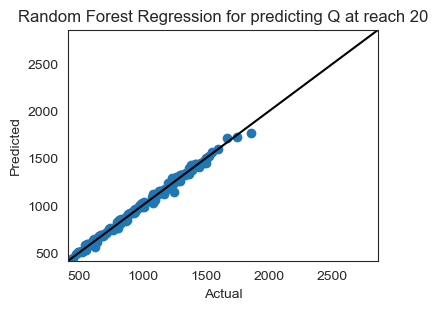

In [199]:
plt.figure(figsize=(4,3))
plt.scatter(y_test, y_pred)

plt.plot([outmin, outmax], [outmin, outmax], color='k', linestyle='-')

lim_tup = (outmin,outmax)
plt.ylim(lim_tup)
plt.xlim(lim_tup)

plt.xlabel("Actual")
plt.ylabel("Predicted")
title = "Random Forest Regression for predicting Q at reach " + str(rn) 
plt.title(title)
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()

In [203]:
#display(rf_imp_df)
MostImp = []
for i in range(n):
    MostImp.append(int(rf_imp_df[i].idxmax()))

countlist = [MostImp.count(i) for i in MostImp]
print(MostImp)
print(countlist)
display(well_loc_df.loc[MostImp])

[462]
[1]


,0,1
462,13,33


In [160]:
#Save the importance DF for later
#rf_imp_df.to_pickle('outputs/importance/SSTest9Diff_RF_Impdf.pkl')

C:\Users\davem\Documents\Thesis\mf-trees\treeFuncs.py:120: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2.set_under("k")


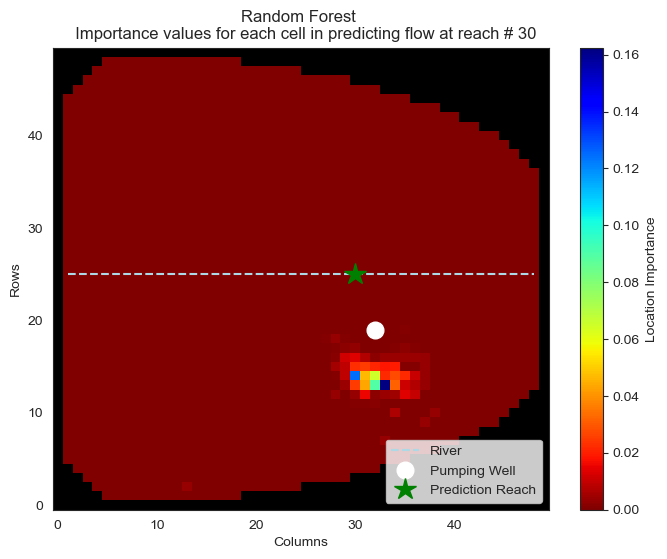

In [204]:
title_rf = 'Random Forest \n  Importance values for each cell in predicting flow at reach # ' + str(rn)
wellmesh_rf = plotImportance(rf_imp_df,well_head_noRiv, well_loc_df,numTS,1,rn,title_rf)
#plt.plot(20, 25, marker="*", markersize=16, color="Green", linestyle = "None",label="Prediction Reach")

# wellmesh_rf_32 = plotImportance(rf_imp_df_32,well_head_noRiv, well_loc_df,numTS,1,rn,title_rf)
# wellmesh_rf_37 = plotImportance(rf_imp_df_37,well_head_noRiv, well_loc_df,numTS,1,rn,title_rf)
#title_rf = 'Random Forest \n  Importance values for each cell in predicting flow at reach ' + str(20)
#wellmesh_rf_20 = plotImportance(rf_imp_df_37,well_head_noRiv, well_loc_df,numTS,1,20,title_rf)


### Testing the parameters as features
Using a single decision tree and the reach 32 out flow

Shape of Input Samples: (957, 8)
Shape of Output Targets: (957,)
Total time: 0.03500556945800781
Fraction of wet simulations: 1.0
bias        0.149412
rmse      192.559403
r           0.988182
nse         0.976384
lognse      0.973474
kge         0.986775
dtype: float64


Text(0.5, 1.0, 'Example Random Decision Tree Regression for Q at reach 32')

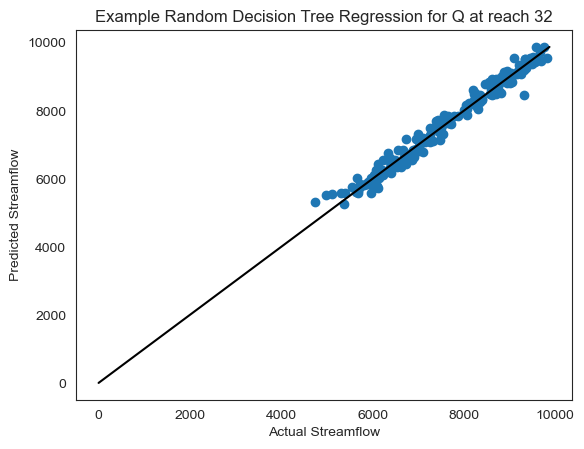

In [128]:
t0 = time.time()
n = 1
pars = X.loc[well_head_noRiv.index]
imp_df_pars, metrics_df_pars, pars_impurity_list, parsTree, y_test, y_pred = trainAndEvaluateModel(DecisionTreeRegressor, pars, new_zone_q[rn],None, 0.2, n, random_state)  

t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[rn]> 0].index) / len(new_zone_q.index)))

#print(metrics_df_rand.mean(),metrics_df_rand.std())
print(metrics_df_pars.mean())
plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_pred) +1
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
title = "Example Random Decision Tree Regression for Q at reach " + str(rn)
plt.title(title)

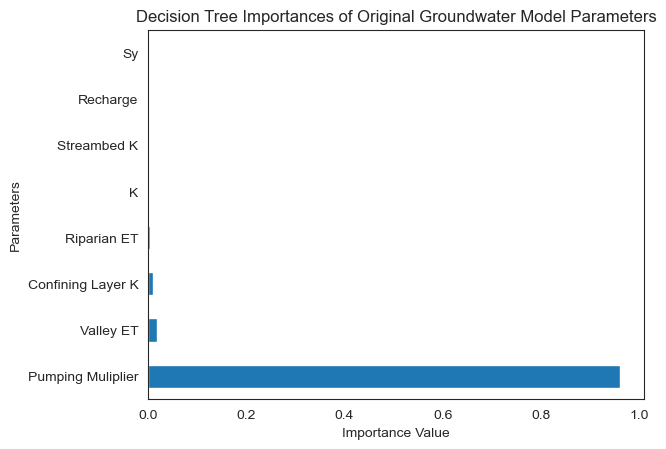

In [129]:
plot_par_names = ['K', 'Confining Layer K', 'Sy', 'Recharge', 'Valley ET', 'Riparian ET', 'Streambed K','Pumping Muliplier']
feat_importances = pd.Series(parsTree.feature_importances_, index=plot_par_names)
feat_importances.nlargest(10).plot(kind='barh',)
plt.xlabel('Importance Value')
plt.ylabel('Parameters')
plt.title('Decision Tree Importances of Original Groundwater Model Parameters')
plt.show()

In [ ]:
#set up the meshgrid   
kk = np.arange(0,50)
gg = np.arange(0,50)
GG, KK = np.meshgrid(gg,kk)


river = np.ndarray((48,))
river[:] = 25

cmap_bd = cm.get_cmap("gray")#,lut=20)
cmap_bd.set_under("w")
cmap_bd.set_over("k")
wellmesh_bd = np.ndarray((50,50))
wellmesh_bd[:,:] = -1e30
for k in range(len(all_well_loc)):
        wellmesh_bd[int(all_well_loc[k, 1]), int(all_well_loc[k, 0])] = 2

cmap_rf = mp.colormaps.get_cmap("Greens")
wellmesh_rf_masked = np.ma.masked_array(wellmesh_rf, wellmesh_rf < 0.001)

cmap_gr = mp.colormaps.get_cmap("Purples")
wellmesh_gr_masked = np.ma.masked_array(wellmesh_rf_32, wellmesh_rf_32 < 0.001)

cmap_dt = mp.colormaps.get_cmap("Blues")
wellmesh_dt_masked = np.ma.masked_array(wellmesh_rf_37, wellmesh_rf_37 < 0.001)

cmap_rand = mp.colormaps.get_cmap("Reds")
wellmesh_rand_masked = np.ma.masked_array(wellmesh_rf_20, wellmesh_rf_20 < 0.01)

# combine them and build a new colormap
colors = np.vstack((cmap_rf(np.linspace(0.,1,128)), cmap_gr(np.linspace(0.,1,128)), cmap_dt(np.linspace(0.,1,128)),cmap_rand(np.linspace(0.,1,128))))
print(colors)
vmin= 0.001
vmax= 0.05
mymap = mp.colors.LinearSegmentedColormap.from_list('Merged',colors)
fig, axs = plt.subplots(figsize=(10,12))
#plt.figure(figsize=(8,10))
alpha = 0.6
axs.pcolormesh(KK,GG,wellmesh_bd,vmax = vmax, vmin = vmin, cmap = cmap_bd, shading='nearest', alpha = 0.05)
axs.pcolormesh(KK,GG,wellmesh_rand_masked,vmax = vmax, vmin = vmin, cmap = cmap_rand, shading='nearest', alpha = alpha)
axs.pcolormesh(KK,GG,wellmesh_dt_masked,vmax = vmax, vmin = vmin, cmap = cmap_dt, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Decision Tree", shrink = 0.25, pad = 0.05, anchor = (0,0.25), location ='bottom').set_ticks([])
axs.pcolormesh(KK,GG,wellmesh_rf_masked,vmax = vmax, vmin = vmin, cmap = cmap_rf, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Random Forest", shrink = 0.25, anchor = (0.3,0.75), location ='bottom').set_ticks([])
axs.pcolormesh(KK,GG,wellmesh_gr_masked,vmax = vmax, vmin = vmin, cmap = cmap_gr, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Gradient Boosted", shrink = 0.25, anchor = (0.75,1), location ='bottom').set_ticks([])
axs.pcolormesh(KK,GG,wellmesh_rand_masked,vmax = vmax, vmin = vmin, cmap = cmap_rand, shading='nearest', alpha = alpha)

#plt.colorbar(cmap = mymap, location = 'bottom')


axs.plot(range(1,49),river, color="lightblue", label='River')
axs.plot(32, 21, marker="x", markersize=8, color="Black", linestyle = "None", label="Pumping Well")
axs.plot(25, 25, marker="*", markersize=10, color="Green", linestyle = "None",label="Prediction Reach")
axs.plot(32, 25, marker="*", markersize=10, color="Purple", linestyle = "None",label="Prediction Reach")
axs.plot(37, 25, marker="*", markersize=10, color="Blue", linestyle = "None",label="Prediction Reach")
axs.plot(20, 25, marker="*", markersize=10, color="Red", linestyle = "None",label="Prediction Reach")

axs.set_xlabel('Columns')
axs.set_ylabel('Rows')
axs.set_title('Random Forest Importance values for each cell in predicting flow at reach ' + str(rn) + ' for 3 different target reaches ')
axs.legend(loc="lower right")
#axs[1].axis('off')
cbar = fig.colorbar(mp.cm.ScalarMappable(cmap=mymap), drawedges = False, ax = axs,label = 'Importance Gradients (darker = more important)', orientation = 'horizontal', ticks = [0,0.1,0.35,0.6,0.85,1],pad = 0.1, shrink = 0.75)
cbar.ax.set_xticklabels(['','Reach 20','Reach 25', 'Reach 32','Reach 37',''])
#plt.legend()